https://salzis.wordpress.com/2014/06/10/robust-linear-model-estimation-using-ransac-python-implementation/

http://www.cse.yorku.ca/~kosta/CompVis_Notes/ransac.pdf

## RANdom SAmple Consensus

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
import sys

# Ransac parameters
ransac_iterations = 10  # number of iterations    -> K value - 
ransac_threshold = 10    # threshold -> epsilon value

#ransac_ratio = 0.6      # ratio of inliers required to assert   # maybe kill this
                        # that a model fits well to data

# generate sparse input data
n_samples = 500               # number of input points
outliers_ratio = 0.2          # ratio of outliers

n_inputs = 1
n_outputs = 1
 
# generate samples
x = 30*np.random.random((n_samples,n_inputs) )
 
# generate line's slope (called here perfect fit)
perfect_fit = 0.5*np.random.normal(size=(n_inputs,n_outputs) )
 
# compute output
y = scipy.dot(x,perfect_fit)


In [2]:
# add a little gaussian noise
x_noise = x + np.random.normal(size=x.shape)
y_noise = y + np.random.normal(size=y.shape)
 
# add some outliers to the point-set
n_outliers = int(outliers_ratio*n_samples)
indices = np.arange(x_noise.shape[0])
np.random.shuffle(indices)
outlier_indices = indices[:n_outliers]
 
x_noise[outlier_indices] = 30*np.random.random(size=(n_outliers,n_inputs))
 
# gaussian outliers
y_noise[outlier_indices] = 30*np.random.normal(size=(n_outliers,n_outputs))

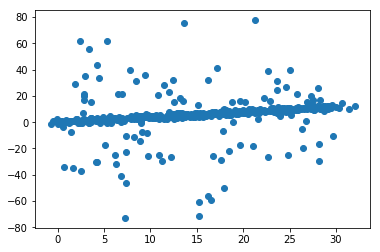

In [3]:
plt.scatter(x_noise,y_noise)

In [4]:
def find_line_model(points,thresh):
    """ find a line model for the given points
    :param points selected points for model fitting
    :return line model
    """

    # [WARNING] vertical and horizontal lines should be treated differently
    #           here we just add some noise to avoid division by zero

    # find a line model for these points
    m = (points[1,1] - points[0,1]) / (points[1,0] - points[0,0] + sys.float_info.epsilon)  # slope (gradient) of the line
    c = points[1,1] - m * points[1,0]                                     # y-intercept of the line
    c_upper = c+thresh
    c_lower = c-thresh
    return m, c, c_upper, c_lower
  
  
  
#   
  
def find_intercept_point(m, c, x0, y0):
    """ find an intercept point of the line model with
        a normal from point (x0,y0) to it
    :param m slope of the line model
    :param c y-intercept of the line model
    :param x0 point's x coordinate
    :param y0 point's y coordinate
    :return intercept point
    """

    # intersection point with the model
    x = (x0 + m*y0 - m*c)/(1 + m**2)
    y = (m*x0 + (m**2)*y0 - (m**2)*c)/(1 + m**2) + c

    return x, y

In [5]:
def ransac_plot(n, x, y, m, c, c_up,c_low,final=False, x_in=(), y_in=(), points=()):
    """ plot the current RANSAC step
    :param n      iteration
    :param points picked up points for modeling
    :param x      samples x
    :param y      samples y
    :param m      slope of the line model
    :param c      shift of the line model
    :param c_up   upper line of threshold
    :param c_low  lower line of threshold
    :param x_in   inliers x
    :param y_in   inliers y
    """

#     fname = "output/figure_" + str(n) + ".png"
    line_width = 1.
    line_color = '#0080ff'
    title = 'iteration ' + str(n)



    plt.figure("Ransac", figsize=(15., 15.))

    # grid for the plot
    grid = [min(x) - 10, max(x) + 10, min(y) - 20, max(y) + 20]
    plt.axis(grid)

    # put grid on the plot
    plt.grid(b=True, which='major', color='0.75', linestyle='--')
    #plt.xticks([i for i in range(min(x) - 10, max(x) + 10, 5)])
    #plt.yticks([i for i in range(min(y) - 20, max(y) + 20, 10)])

    # plot input points
    plt.plot(x[:,0], y[:,0], marker='o', label='Input points', color='#00cc00', linestyle='None', alpha=0.4)

    # draw the current model
    plt.plot(x, m*x + c, 'r', label='Line model', color=line_color, linewidth=line_width)
    
    # draw the current model
    plt.plot(x, m*x + c_up, 'r', label='Line model', color=line_color, linewidth=line_width)
    
    # draw the current model
    plt.plot(x, m*x + c_low, 'r', label='Line model', color=line_color, linewidth=line_width)

    # draw inliers
    if not final:
        plt.plot(x_in, y_in, marker='o', label='Inliers', linestyle='None', color='#ff0000', alpha=0.6)

    # draw points picked up for the modeling
    if not final:
        plt.plot(points[:,0], points[:,1], marker='o', label='Picked points', color='#0000cc', linestyle='None', alpha=0.6)

    plt.title(title)
    plt.legend()
#     plt.savefig(fname)
    plt.show()

  inlier ratio =  0.846


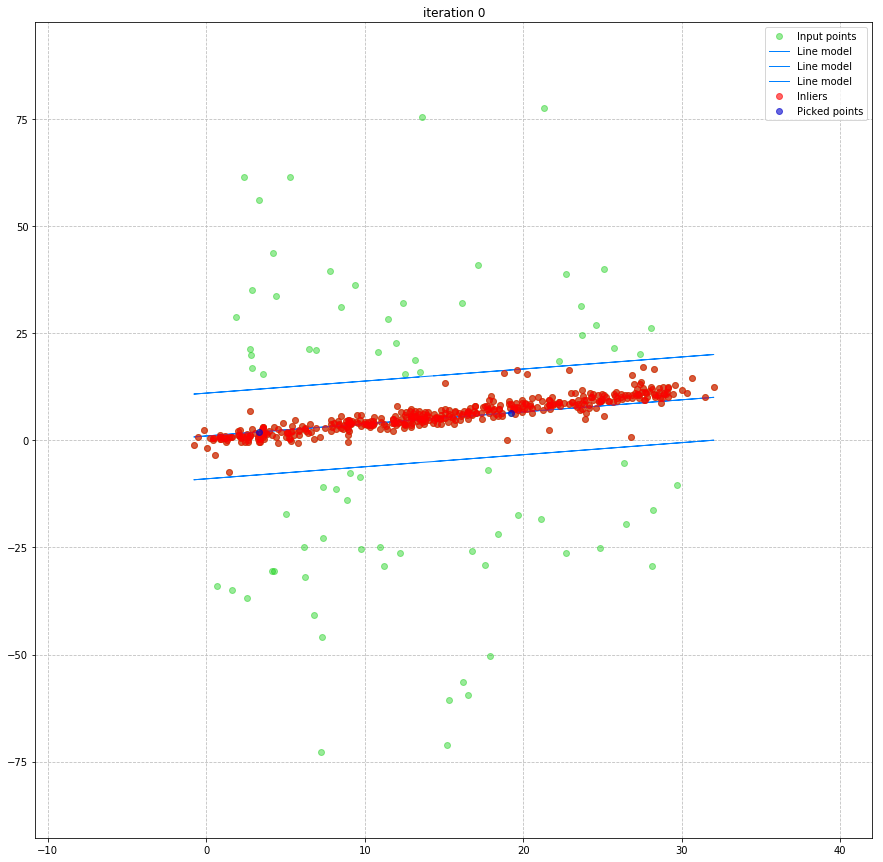

  inlier ratio =  0.85


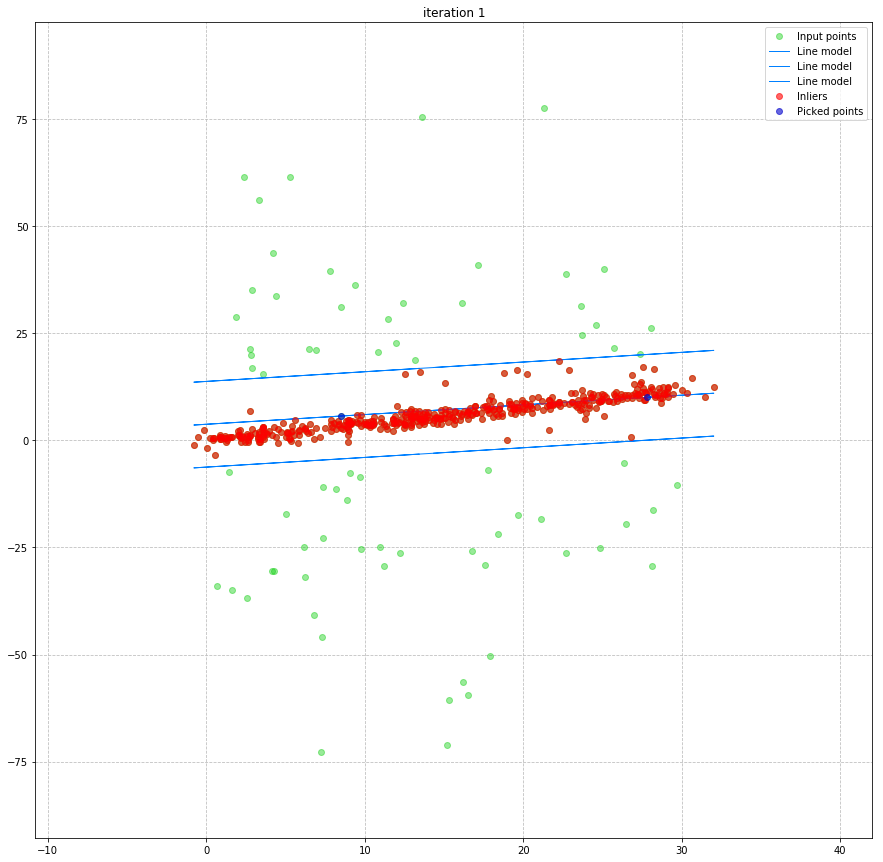

  inlier ratio =  0.854


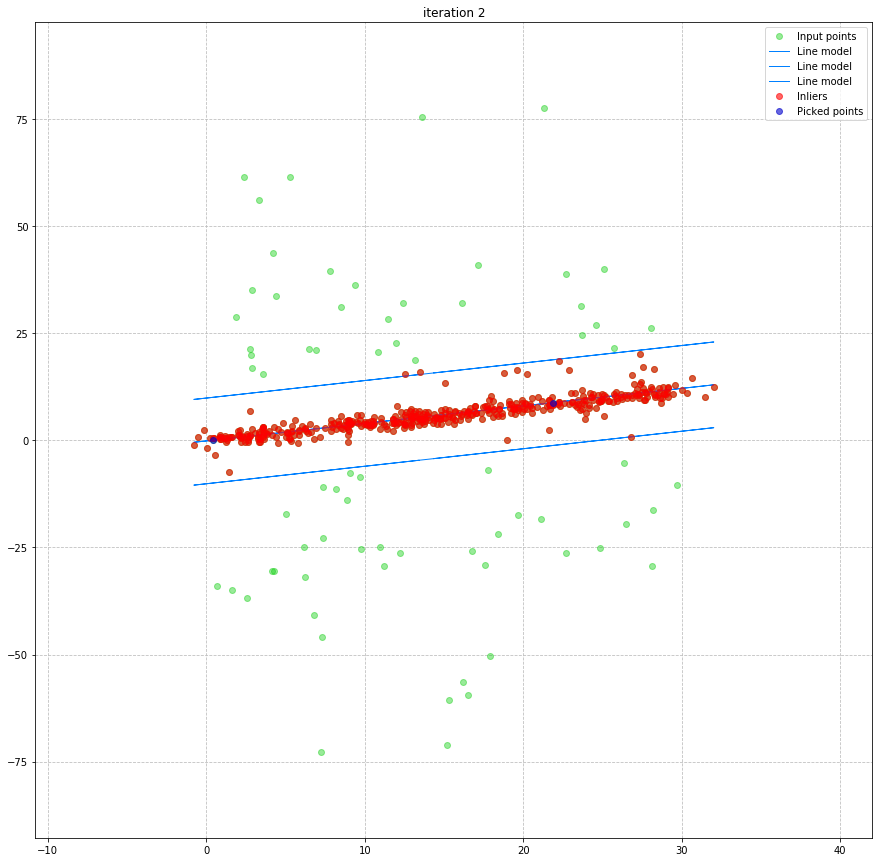

  inlier ratio =  0.834


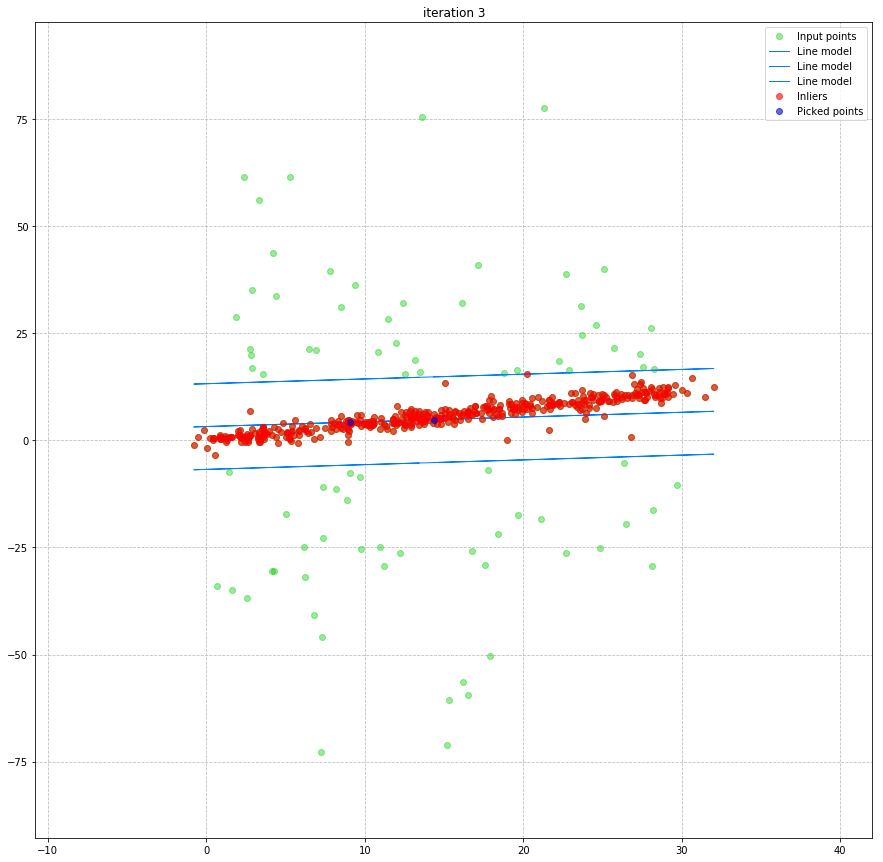

  inlier ratio =  0.586


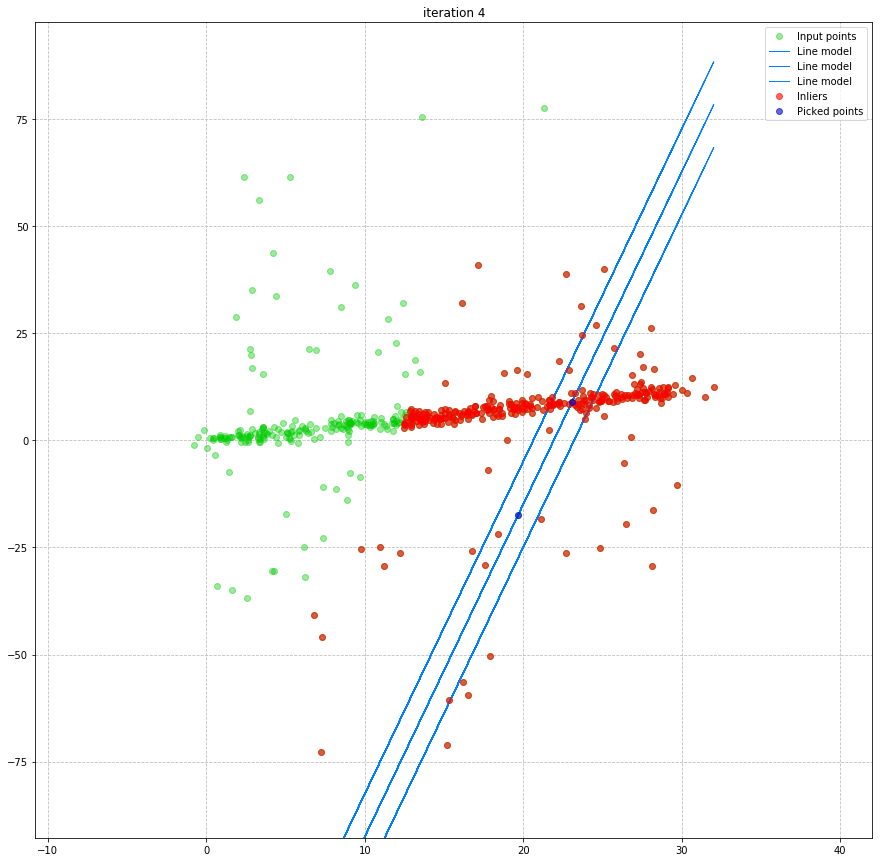

  inlier ratio =  0.474


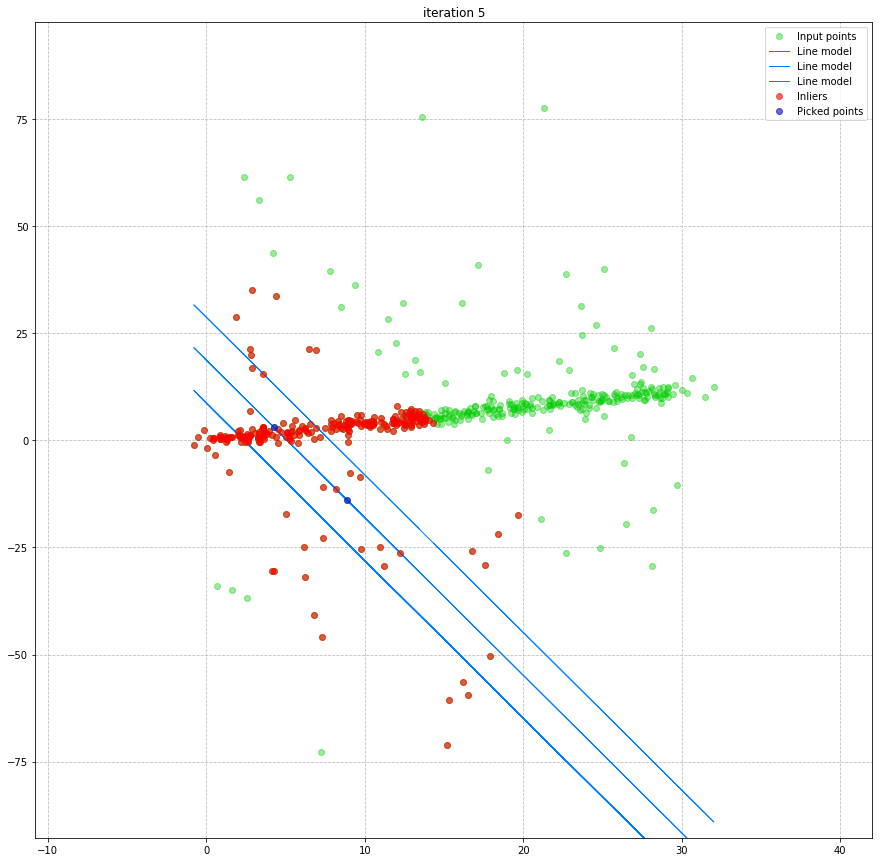

  inlier ratio =  0.548


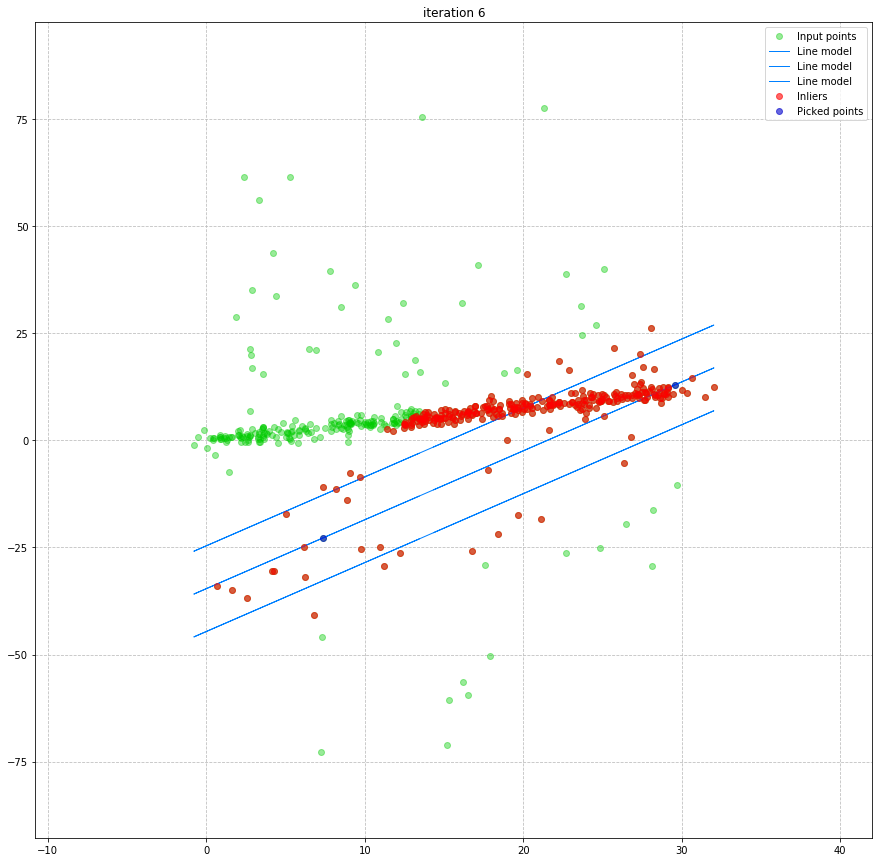

  inlier ratio =  0.854


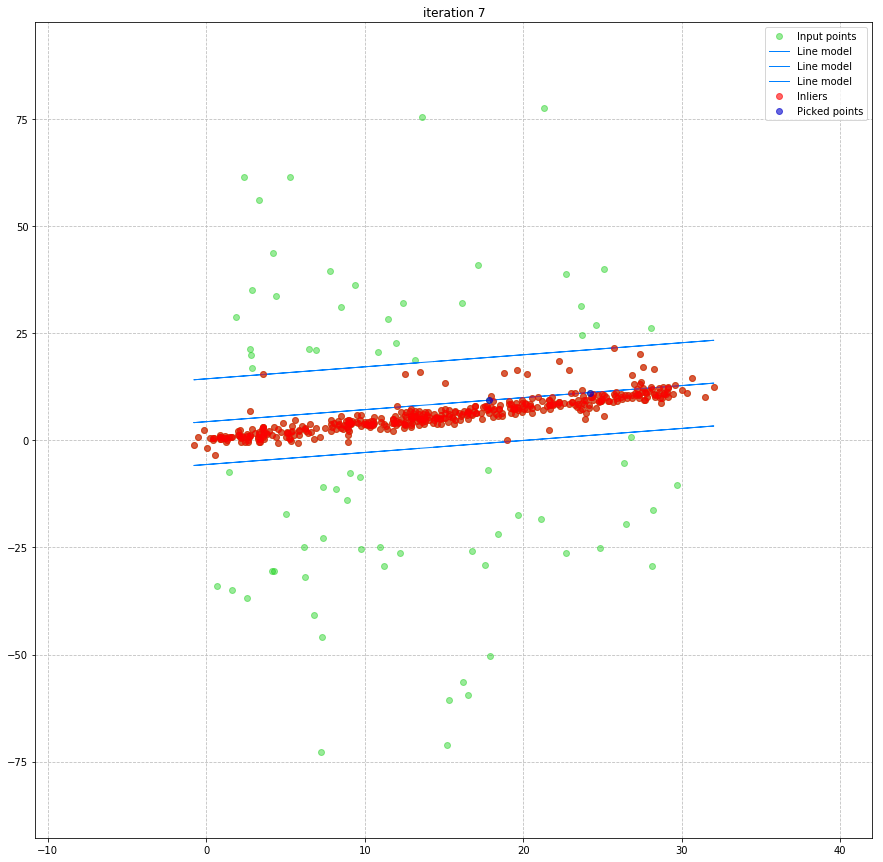

  inlier ratio =  0.398


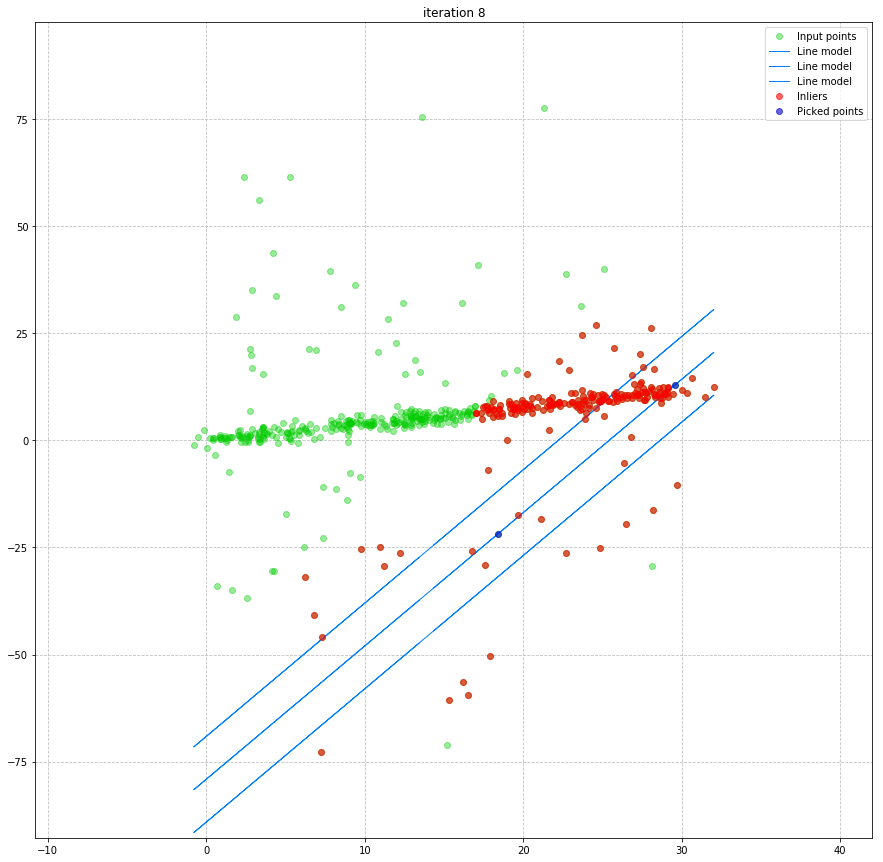

  inlier ratio =  0.55


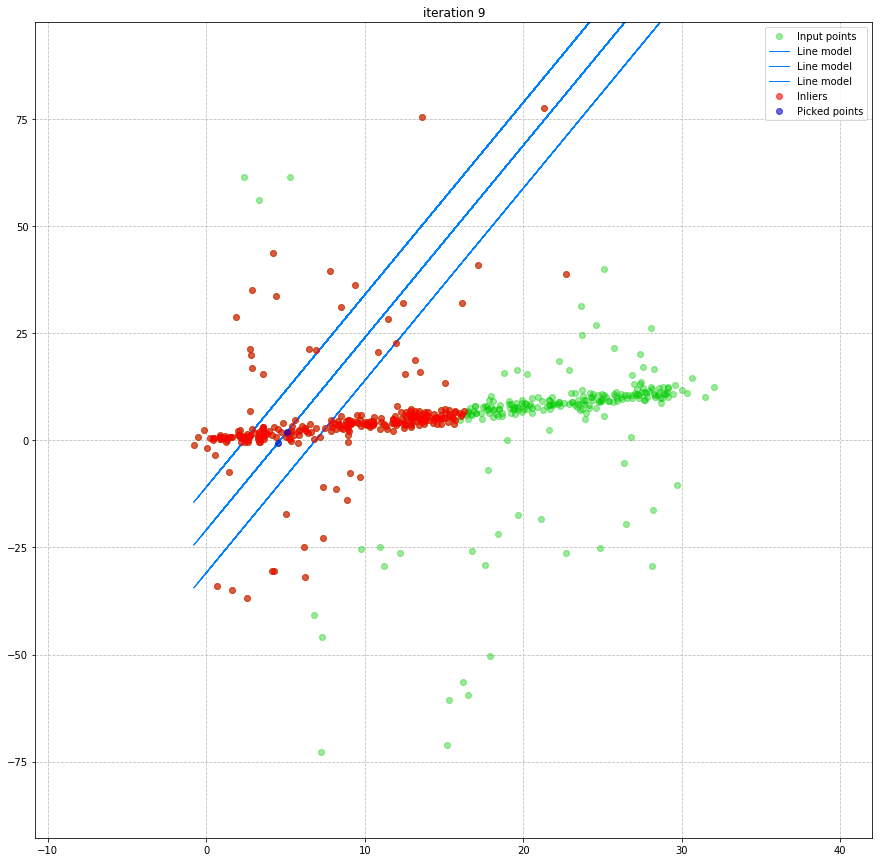

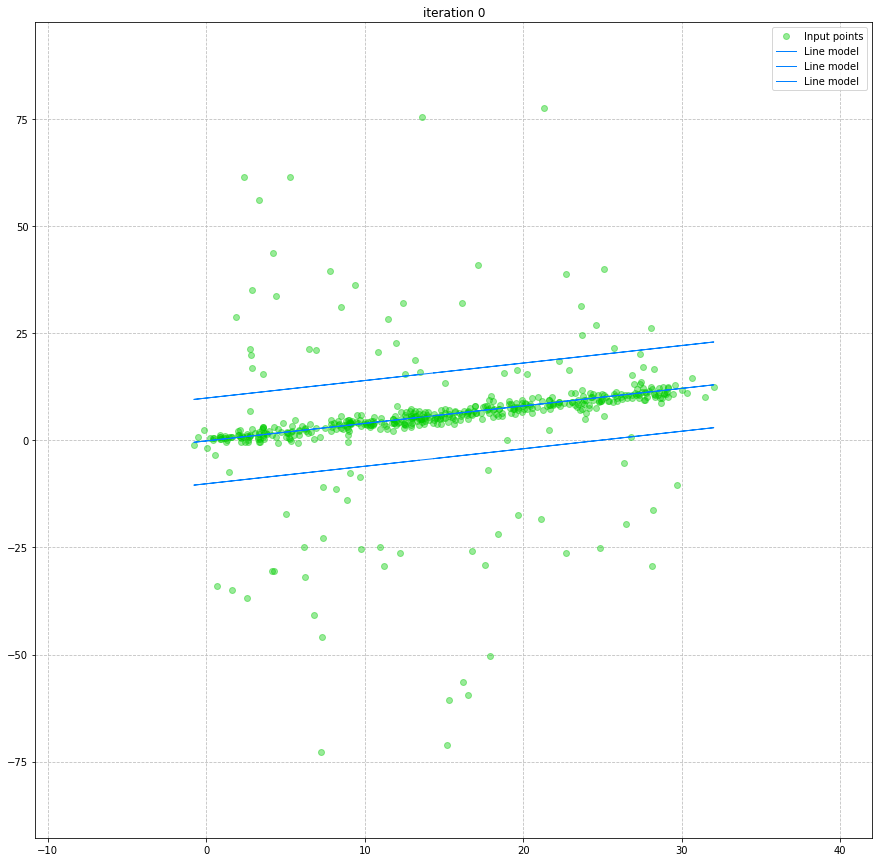


Final model:

  ratio =  0.854
  model_m =  0.4087698191913003
  model_c =  -0.1535772554873422


In [6]:
data = np.hstack( (x_noise,y_noise) )

ratio = [] # going to store the inlier ratio for each iteration
model_m = [] # store the slopes
model_c = [] # store the intercepts


# perform RANSAC iterations
for it in range(ransac_iterations):

    # pick up two random points
    n = 2

    all_indices = np.arange(x_noise.shape[0])
    np.random.shuffle(all_indices)

    indices_1 = all_indices[:n]
    indices_2 = all_indices[n:]

    maybe_points = data[indices_1,:]
    test_points = data[indices_2,:]

    # find a line model for these points
    m, c, c_up, c_low = find_line_model(maybe_points,ransac_threshold)

    x_list = []
    y_list = []
    num = 0

    # find orthogonal lines to the model for all testing points
    for ind in range(test_points.shape[0]):

        x0 = test_points[ind,0]
        y0 = test_points[ind,1]

        # find an intercept point of the model with a normal from point (x0,y0)
        x1, y1 = find_intercept_point(m, c, x0, y0)

        # distance from point to the model
        dist = math.sqrt((x1 - x0)**2 + (y1 - y0)**2)

        # check whether it's an inlier or not
        if dist < ransac_threshold:
            x_list.append(x0)
            y_list.append(y0)
            num += 1

    x_inliers = np.array(x_list)
    y_inliers = np.array(y_list)

    # in case a new model is better - cache it
    #if num/float(n_samples) > ratio:
    
    ratio.extend([num/float(n_samples)])
    model_m.extend([m])
    model_c.extend([c])

    print('  inlier ratio = ', num/float(n_samples))
    #print('  model_m = ', model_m)
    #print('  model_c = ', model_c)

    # plot the current step
    ransac_plot(it, x_noise,y_noise, m, c, c_up,c_low, False, x_inliers, y_inliers, maybe_points)

#     # we are done in case we have enough inliers
#     if num > n_samples*ransac_ratio:
#         print('The model is found !')
#         break
        

        
        
# plot the final model
max_ind = ratio.index(max(ratio))
best_model_m = model_m[max_ind]
best_model_c = model_c[max_ind]

ransac_plot(0, x_noise,y_noise, best_model_m, best_model_c, (best_model_c+ransac_threshold),(best_model_c-ransac_threshold), True)
 
print('\nFinal model:\n')
print('  ratio = ', ratio[max_ind])
print('  model_m = ', best_model_m)
print('  model_c = ', best_model_c)

In [28]:
ratio

[0.38, 0.174, 0.198, 0.172, 0.028, 0.354, 0.208, 0.206, 0.19, 0.154]